# Analyze A/B Test Results



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [References](#ref)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [38]:
import pandas as pd               # dealing with csv files
import numpy as np                # to deal with arrays more efficiently
import random                     # to create random data
import statsmodels.api as sms;    # to use in statistics
import matplotlib.pyplot as plt   # to create figures and plots
import seaborn as sns             # to make a better visualizations
% matplotlib inline
#Setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

a. Read in the dataset and take a look at the top few rows here:

In [39]:
df = pd.read_csv('ab_data.csv')  # reading the data
df.head()                        # displaying the first few rows 

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [40]:
df.info()  # displaying info about the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


c. The number of unique users in the dataset.

In [41]:
df.user_id.nunique()  # display how many unique users using nunique

290584

d. The proportion of users converted.

In [42]:
print(str(df.converted.mean()) + ' %') # just formatting the output 

0.119659193556 %


e. The number of times the `new_page` and `treatment` don't line up.

In [43]:
df_condition = df[(df['landing_page'] == 'new_page') == (df['group'] != 'treatment' )]
df_condition.info()  # getting information about the new dataframe under these specific conditions

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3893 entries, 22 to 294331
Data columns (total 5 columns):
user_id         3893 non-null int64
timestamp       3893 non-null object
group           3893 non-null object
landing_page    3893 non-null object
converted       3893 non-null int64
dtypes: int64(2), object(3)
memory usage: 182.5+ KB


f. Do any of the rows have missing values?

In [44]:
if(sum(df.isnull().sum())):  # if statement to decide whether there is missing values or no
    print('Yes')
else:
    print('No')

No


`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page. How should we handle that?

`Answer:` These rows must be removed, since the meaning of the test itself becomes inconsistent at these conditions.

a. Removing these rows with the following line of code

In [45]:
df2 = df[(df['landing_page'] == 'new_page') == (df['group'] == 'treatment' )]

In [46]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [47]:
df2.info() # getting information about the new dataframe

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 0 to 294477
Data columns (total 5 columns):
user_id         290585 non-null int64
timestamp       290585 non-null object
group           290585 non-null object
landing_page    290585 non-null object
converted       290585 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


a. How many unique **user_id**s are in **df2**?

In [48]:
df2.user_id.nunique()  #  display how many unique users using nunique

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [49]:
df_temp = df2[df2.user_id.duplicated()] # creating a temporary dataframe by masking the original one

c. What is the row information for the repeat **user_id**? 

In [50]:
df_temp.head() # displaying the content of the new dataframe

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [51]:
df2 = df2.drop_duplicates('user_id', inplace=False);

In [52]:
df2.info()  # checking that the operation is successful 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 294477
Data columns (total 5 columns):
user_id         290584 non-null int64
timestamp       290584 non-null object
group           290584 non-null object
landing_page    290584 non-null object
converted       290584 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


Great! now the duplicated sample has been removed! 

Now, by calculating some basic probabilities.

a. What is the probability of an individual converting regardless of the page they receive?

In [53]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [54]:
df_control = df2.query('group == "control"')
df_control.converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [55]:
df_treatment = df2.query('group == "treatment"')
df_treatment.converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [56]:

df2.groupby('landing_page')['user_id'].count()[0]/df2.shape[0]

0.50006194422266881

e. Use the results in the previous two portions of this question to suggest if you think there is evidence that one page leads to more conversions?  Write your response below.

Since the probability that a user received the new page is 50 %. Given that an individual was in the treatment group, the probability they converted is greater than the probability they converted given that this individual belonged to treatment group, the NULL hypothesis (The old page is better than the new one) is True, and the old page leads to more conversions.

**Limitations**
This result might be baised for the following reason: 

*Change Aversion*: Existing users may give an unfair advantage to the old version, simply because they are unhappy with change, even if it’s ultimately for the better.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$H_{0}$ : $P_{new}$ - $P_{old}$ <= 0

$H_{1}$ : $P_{new}$ - $P_{old}$ > 0

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [57]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [58]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [59]:
n_new = df_treatment.shape[0] 
n_new

145310

d. What is $n_{old}$?

In [60]:
n_old = df_control.shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [61]:
new_page_converted = np.random.binomial(n_new,p_new) # simulating

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [62]:
old_page_converted = np.random.binomial(n_old,p_old) # simulating

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [63]:
new_page_converted/n_new - old_page_converted/n_old  

-0.0006906130902658986

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [64]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.binomial(n_new,p_new)
    old_page_converted = np.random.binomial(n_old,p_old)
    p_diffs.append(new_page_converted/n_new - old_page_converted/n_old)    

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

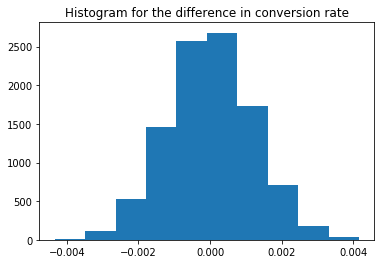

In [65]:
p_diffs = np.array(p_diffs)
plt.hist(p_diffs);
plt.title('Histogram for the difference in conversion rate');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [66]:
diff = df2[df2['group'] == 'treatment']['converted'].mean() -  df2[df2['group'] == 'control']['converted'].mean()
(diff < p_diffs).mean()

0.90800000000000003

k. In words, explain what you just computed in part **j.**.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

This is the $p_{value}$.

The $p_{value}$  is the probability of observing your statistic (or one more extreme in favor of the alternative) if the null hypothesis is true. 

Since the $p_{value}$ is greater than *alpha level* this suggests that there is a statistically significant difference, which suggest the new page conversion rate is higher than the old rate.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [67]:
import statsmodels.api as sm

convert_old = df2.query("landing_page == 'old_page' and converted == 1").shape[0]
convert_new = df2.query(" landing_page == 'new_page' and converted == 1").shape[0]
n_old = df2[df2['group'] == 'control'].shape[0]
n_new = df2[df2['group'] == 'treatment'].shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [68]:
(z_value, p_value) = sms.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
z_value, p_value

(1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

Again high $p_{value}$ means that we can't reject the NULL hypothesis, and this result perfectly agress with the previous parts.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

Linear Regression - more specifically speaking, it's a multiple Linear Regression.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [69]:
df2['intercept'] = 1
page_dummies = pd.get_dummies(df['landing_page'])
df2[['ab_page','baseline']] = page_dummies
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,baseline
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [70]:
lm = sm.OLS(df2['converted'], df2[['intercept', 'ab_page']])
results = lm.fit()

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [71]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              converted   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.719
Date:                Wed, 01 Aug 2018   Prob (F-statistic):              0.190
Time:                        05:54:54   Log-Likelihood:                -85267.
No. Observations:              290584   AIC:                         1.705e+05
Df Residuals:                  290582   BIC:                         1.706e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1204      0.001    141.407      0.000       0.119       0.122
ab_page       -0.0016      0.001     -1.311      0.190      -0.004       0.001
==============================================================================
Omnibus:                   125553.456   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           414313.355
Skew:                           2.345   Prob(JB):                         0.00
Kurtosis:                       6.497   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

The $p_{value}$ is 0.190. 

The hypothesis associated with the regession model is 
$$ H_0: p_{new} = p_{old} $$$$ H_1: p_{new} \neq p_{old} $$

Which differs from the hypothesis from the previous part.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

Yes it's in general a good idea to consider other factors to avoid misleading conclusions. 

Disadvantages are that if we add high correlations predictor variables, leading to unreliable and unstable estimates of regression coefficients (Multicollinearity) can affect our model.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Yes the country had an impact on conversion.

In [72]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,baseline
user_id,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0


In [73]:
neighborhood_dummies = pd.get_dummies(df_new['country'])
df_new = df_new.join(neighborhood_dummies)
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,baseline,CA,UK,US
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,0,1,0


In [74]:
lm = sm.OLS(df_new['converted'], df_new[['intercept', 'UK', 'US']])
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              converted   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.605
Date:                Wed, 01 Aug 2018   Prob (F-statistic):              0.201
Time:                        05:54:55   Log-Likelihood:                -85267.
No. Observations:              290584   AIC:                         1.705e+05
Df Residuals:                  290581   BIC:                         1.706e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1153      0.003     42.792      0.000       0.110       0.121
UK             0.0053      0.003      1.787      0.074      -0.001       0.011
US             0.0042      0.003      1.516      0.130      -0.001       0.010
==============================================================================
Omnibus:                   125552.384   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           414306.036
Skew:                           2.345   Prob(JB):                         0.00
Kurtosis:                       6.497   Cond. No.                         9.94
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [75]:
lm = sm.OLS(df_new['converted'], df_new[['intercept', 'US', 'UK', 'ab_page']])
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              converted   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.640
Date:                Wed, 01 Aug 2018   Prob (F-statistic):              0.178
Time:                        05:54:55   Log-Likelihood:                -85266.
No. Observations:              290584   AIC:                         1.705e+05
Df Residuals:                  290580   BIC:                         1.706e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1161      0.003     42.036      0.000       0.111       0.122
US             0.0042      0.003      1.514      0.130      -0.001       0.010
UK             0.0053      0.003      1.784      0.074      -0.001       0.011
ab_page       -0.0016      0.001     -1.307      0.191      -0.004       0.001
==============================================================================
Omnibus:                   125551.169   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           414297.780
Skew:                           2.345   Prob(JB):                         0.00
Kurtosis:                       6.497   Cond. No.                         10.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

> **Concusions**:
Considering more than only one factor is regression is in most cases a good idea, that results in avoiding misleading conclusions.

<a id='ref'></a>
### Refernces
- [How to do superscripts and subscripts in Jupyter Notebook?](https://stackoverflow.com/questions/46011785/how-to-do-superscripts-and-subscripts-in-jupyter-notebook)

In [76]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0